# Time to depth conversion

**Author:** Cristhian Valladares

**Id:** 195877

This notebook shows the time to depth conversion of migration stacks. The project is build on top of the previous a previous project (Semblance analysis and NMO correction for Volve dataset).

### **Objective:**
- Convert a migrated image from the **time domain (TWT)** to the **depth domain**.
- Use the provided RMS velocity model $( V_{RMS} )$ for depth conversion.  

### **Requirements:**
- A stacked seismic section in the time domain.
- A $ V_{RMS} $ velocity model as a function of $ x $ (midpoint) and TWT.  

In [1]:
%load_ext autoreload

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pickle
from scipy.sparse.linalg import lsqr
from pylops.utils.wavelets import *
from pylops.utils import dottest
from timemig import TimeKirchhoff
import segyshot as sg
from scipy.signal import butter, filtfilt

## Previous files Required
- section_z0 obtained from stacked traces after NMO correction
- VRMS model as function of xmid_offset (m) and TWT (s) 

In [2]:
with open('../dchamorro_nmo/section_upper.pickle', 'rb') as handle:
    dstack_section, \
     tmax_section, \
     vrmsmax_section, \
     tmax_c_section, \
     vrmsmax_c_section = pickle.load(handle)

with open('../dchamorro_nmo/section_lower.pickle', 'rb') as handle:
    dstack_section_opposite, \
     tmax_section_opposite, \
     vrmsmax_section_opposite, \
     tmax_c_section_opposite, \
     vrmsmax_c_section_opposite = pickle.load(handle)

In [3]:
section_pos = np.vstack(dstack_section)
section_pos_opposite = np.vstack(dstack_section_opposite)

section_zo = np.vstack((section_pos, section_pos_opposite)).T

Given the receiver distance along the x axis we can obtain the distance between mid array receivers using trigonometry so that this distance is $\Delta x / \sqrt{2}$

In [4]:
xmidaxis = np.arange(200)*25/np.sqrt(2)
time = np.arange(1500) * 0.002
t0axis = time.copy()

## Zero offset stacked image

The zero-offset stacked section represents the seismic amplitudes in the **time domain** (TWT) after NMO correction.  
This section is plotted against the receiver midpoint offset (\( X_{mid} \)).

Text(0, 0.5, 'TWT0 [sec]')

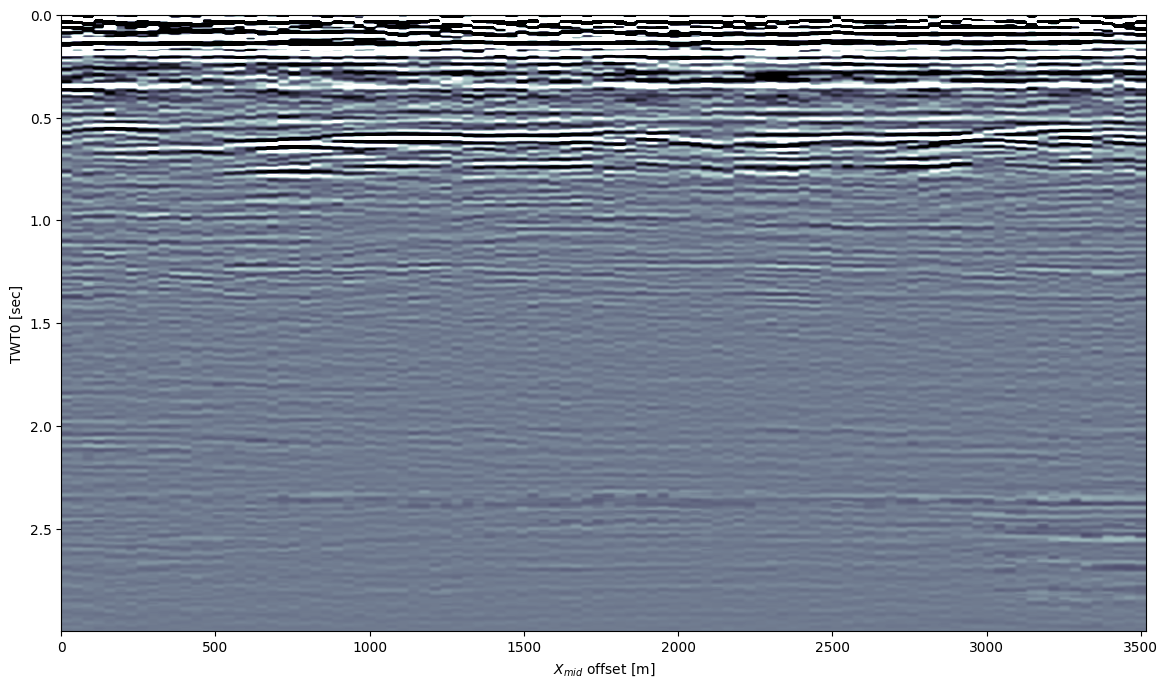

In [5]:
scale = 80
plt.figure(figsize=(14, 8))
plt.imshow(section_zo, aspect='auto', cmap='bone', norm=colors.TwoSlopeNorm(vmin=np.min(
    section_zo)/scale, vcenter=0, vmax=np.max(section_zo)/scale), extent=(xmidaxis[0], xmidaxis[-1], time[-1], time[0]))
plt.xlabel('$X_{mid}$ offset [m]')
plt.ylabel('TWT0 [sec]')

## VRMS model

The RMS velocity model (\( V_{RMS} \)) is interpolated from the input data for each midpoint offset (\( X_{mid} \)) and TWT.  
This model will be used to convert the seismic section from the **time domain (TWT)** to the **depth domain**.

In [6]:
velmodel = np.zeros((1500, 100))
velmodel_opposite = np.zeros((1500, 100))

for i in range(100):
    velmodel[:, i] = np.interp(t0axis, tmax_section[i], vrmsmax_section[i])
    velmodel_opposite[:, i] = np.interp(t0axis, tmax_section_opposite[i], vrmsmax_section_opposite[i])

vrmsmodel = np.hstack((velmodel, velmodel_opposite))

As for the Vrms velocity model we obtained the following results:

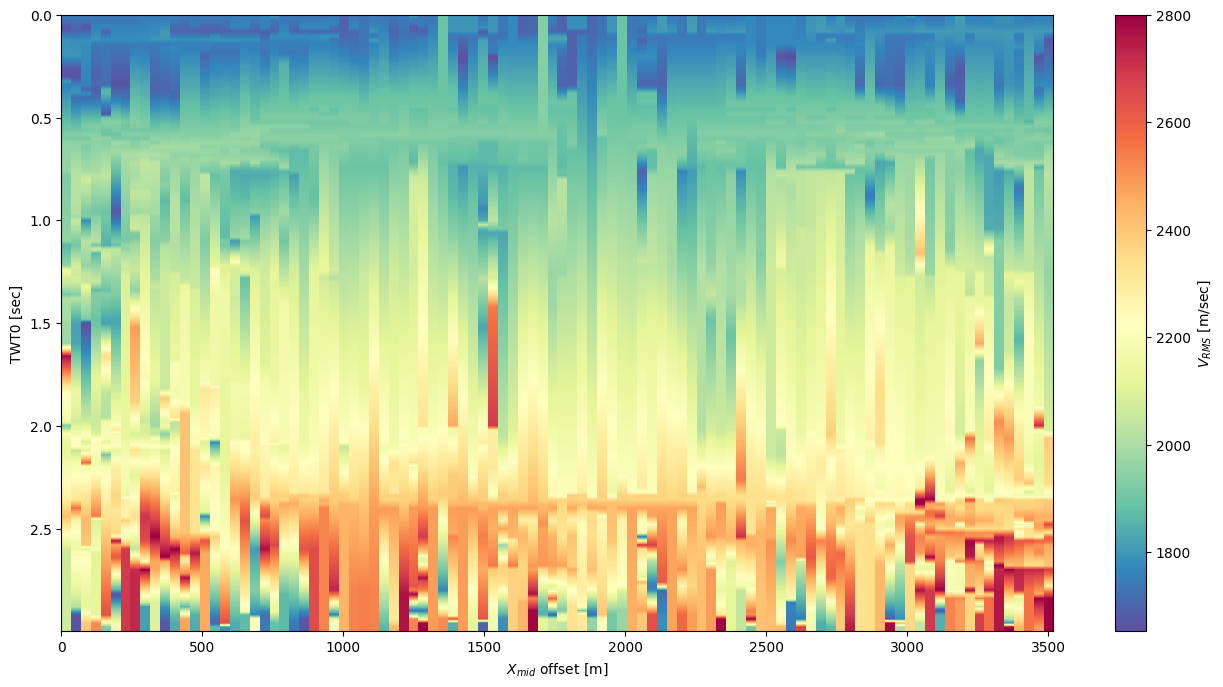

In [7]:
plt.figure(figsize=(16, 8))

plt.imshow(vrmsmodel, aspect='auto', cmap='Spectral_r', extent=(xmidaxis[0], xmidaxis[-1], time[-1], time[0]), interpolation='none')
plt.colorbar(label='$V_{RMS}$ [m/sec]')

plt.xlabel('$X_{mid}$ offset [m]');
plt.ylabel('TWT0 [sec]');

## Frequency Spectrum Analysis

Before depth conversion, we analyze the frequency content of the seismic section.  
This ensures that the data's dominant frequencies align with the processing parameters, such as the wavelet used for migration.

1. Compute the frequency spectrum of the seismic section.
2. Identify the dominant frequency to guide wavelet selection.

In [8]:
#Axes of the TWTO, xmid domain
x = xmidaxis
nx = len(x)
t0 = time
dt = t0[1] - t0[0]
nt0 = len(t0)
#Reflectivity model
data = section_zo.T
#Wavelet
f0 = 25
T = 4 / f0
dt2 = 1 / (5*f0)
twave=np.arange(-T/2,T/2+dt2,dt2)
# t0[:65]
wav, _, wavc = ricker(twave, f0=f0) # wavelet until 0.08s
#VRMS model
vrms = vrmsmodel.T
#Create the Time Kirchhoff operator
Top = TimeKirchhoff(t0, x, vrms, wav, wavc, engine='numba')

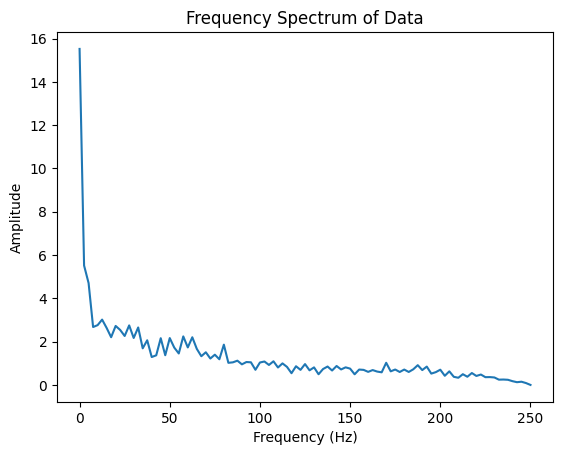

In [9]:
freq = np.fft.rfftfreq(len(data), d=dt)
spectrum = np.sum(np.abs(np.fft.rfft(data, axis=0)), axis=1)

plt.plot(freq, spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Spectrum of Data")
plt.show()

## Preprocessing: Low-Pass Filtering

To suppress high-frequency noise, a Butterworth low-pass filter is applied to the seismic section.  
This step improves the stability of the inversion.

**Key Parameters:**
- **Cutoff Frequency:** 25 Hz. Obtained from the previous analyzed spectrum
- **Filter Order:** 8 (sharp transition between passband and stopband).

**Padding:**
To avoid edge artifacts during filtering:
- The data is padded with mirrored values.
- Padding is removed after filtering.

**Frequency Spectrum Comparison:**
The updated frequency spectrum is plotted to verify noise suppression after filtering.


In [10]:
#Preprocessing the data
def butter_lowpass_filter(amplitude, cutoff_freq, fs, order=4):
    # Normalize the frequency
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist

    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Apply the filter along the time axis (axis=0)
    filtered_amplitude = filtfilt(b, a, amplitude, axis=0)

    return filtered_amplitude

pad_rows = int(0.1 * data.shape[0])
pad_cols = int(0.1 * data.shape[1])

padded_data = np.pad(data, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='reflect')
data_filt = butter_lowpass_filter(padded_data, 25, 1/dt, order=8)
data_filt = data_filt[pad_rows:-pad_rows, pad_cols:-pad_cols]  # Remove padding

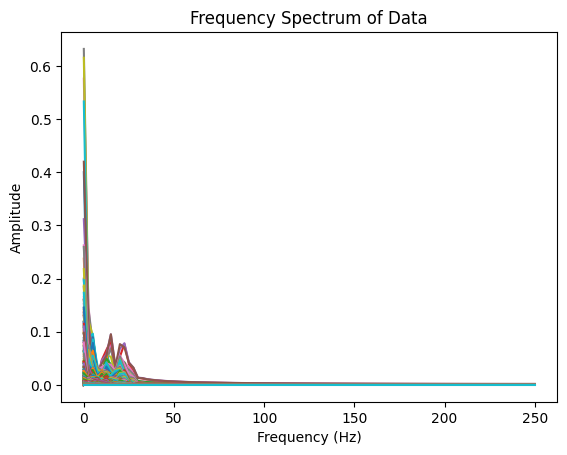

In [11]:
freq = np.fft.rfftfreq(len(data_filt), d=dt)
spectrum = np.abs(np.fft.rfft(data_filt, axis=0))

plt.plot(freq, spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Spectrum of Data")
plt.show()

## Kirchhoff Time Migration

Time migration reconstructs the reflectivity model using the zero-offset seismic section and $ V_{RMS} $.  
This is performed using the **Kirchhoff migration operator**, which integrates along hyperbolic travel times.

**Steps:**
1. Create the Kirchhoff operator based on the RMS velocity model.
2. Migrate the filtered seismic section to produce the reflectivity model.

**Output:**
- Migrated reflectivity image in the time domain (TWT).

### Key Equations in the Kirchhoff Operator

#### 1. **Travel Time Calculation**
The travel time from a source/receiver ($x_\text{src}$) to an imaging point ($x$) is computed as:
$$
t(x, x_\text{src}, t_0) = \sqrt{t_0^2 + \frac{4 (x - x_\text{src})^2}{V_\text{RMS}^2(t_0)}}
$$
Where:
- $t_0$: Two-way travel time (TWT) at zero offset,
- $x$: Imaging point position,
- $x_\text{src}$: Source/receiver position,
- $V_\text{RMS}(t_0)$: RMS velocity.

#### 2. **Data Modeling Operator (Forward)**
The forward operator maps reflectivity ($R(x, t)$) to recorded data ($D(x_\text{src}, t_0)$) via:
$$
D(x_\text{src}, t_0) = \int \int R(x, t) \, W(t_0 - t(x, x_\text{src}, t)) \, dx \, dt
$$
Where:
- $W(t_0)$: Wavelet applied to the reflectivity,
- $t(x, x_\text{src}, t)$: Travel time for each point.

#### 3. **Migration Operator (Adjoint)**
The migration operator reconstructs the reflectivity ($R(x, t)$) from recorded data ($D(x_\text{src}, t_0)$):
$$
R(x, t) = \int \int D(x_\text{src}, t_0) \, W^*(t_0 - t(x, x_\text{src}, t)) \, dx_\text{src} \, dt_0
$$
Where:
- $W^*(t_0)$: Adjoint of the wavelet used in forward modeling.


(2.998, 0.0)

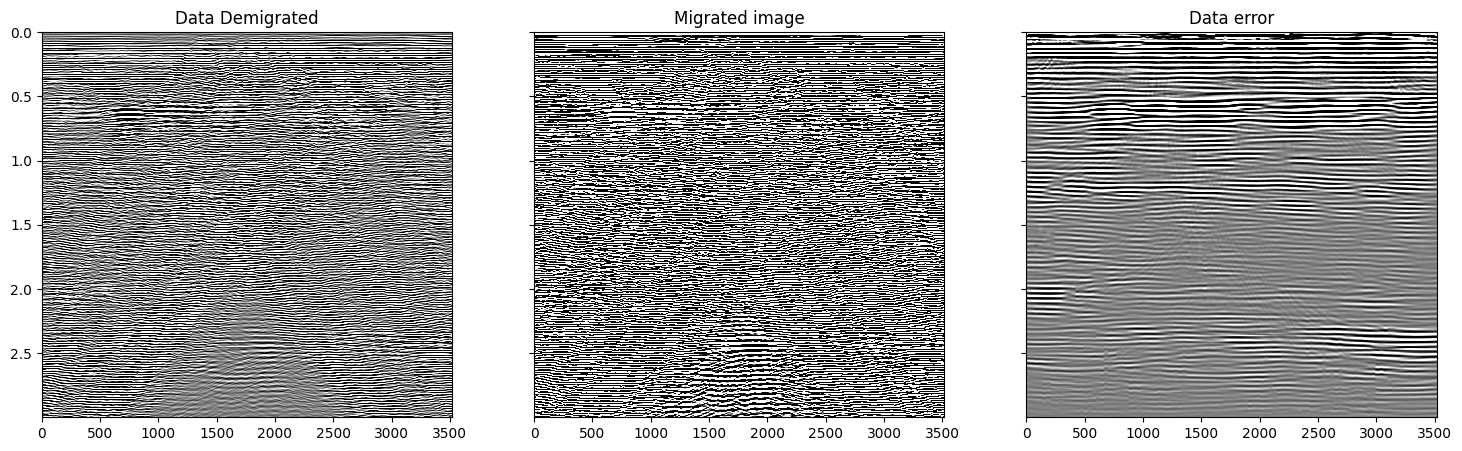

In [12]:
# Model data (demigration)
# data = Top @ refl

# Image data (migration)
scale = 30
reflmig = Top.H @ data_filt
data_demig = Top @ reflmig

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
axs[0].imshow(data_demig.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]), norm=colors.TwoSlopeNorm(vmin=np.min(
    data_demig)/scale, vcenter=0, vmax=np.max(data_demig)/scale))
axs[0].axis('tight')
axs[0].set_title('Data Demigrated')

# axs[1].imshow(data_filt.T, cmap='gray', norm=colors.TwoSlopeNorm(vmin=np.min(
#     data_filt)/scale, vcenter=0, vmax=np.max(data_filt)/scale), extent=(x[0], x[-1], t0[-1], t0[0]))
# axs[1].plot(x, Top.trav[:, nx//2, nt0//2], 'r')
# axs[1].axis('tight')
# axs[1].set_title('Data')

axs[1].imshow(data_filt.T - data_demig.T, cmap='gray', norm=colors.TwoSlopeNorm(vmin=np.min(
    reflmig)/scale, vcenter=0, vmax=np.max(reflmig)/scale), extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axis('tight')
axs[1].set_title('Migrated image')
axs[1].set_ylim(t0[-1], t0[0])

axs[2].imshow(reflmig.T, cmap='gray', norm=colors.TwoSlopeNorm(vmin=np.min(
    reflmig)/scale, vcenter=0, vmax=np.max(reflmig)/scale), extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axis('tight')
axs[2].set_title('Data error')
axs[2].set_ylim(t0[-1], t0[0])

In [13]:
# Migration by inversion (aka least-squares migration)
reflinv = lsqr(Top, data_filt.ravel(), iter_lim=100, damp=1e-2, show=True)[0]
reflinv = reflinv.reshape(nx, nt0)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 300000 rows and 300000 columns
damp = 1.00000000000000e-02   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.468e-01  1.468e-01    1.0e+00  8.2e+00
     1 -8.39741e-07   1.467e-01  1.467e-01    1.0e+00  6.2e-02   3.3e+01  1.0e+00
     2 -1.46652e-06   1.466e-01  1.466e-01    1.0e+00  2.7e-02   9.0e+01  3.9e+00
     3 -2.23369e-06   1.465e-01  1.465e-01    1.0e+00  1.9e-02   1.4e+02  7.7e+00
     4 -3.24967e-06   1.464e-01  1.464e-01    1.0e+00  1.4e-02   1.8e+02  1.2e+01
     5 -4.51139e-06   1.463e-01  1.463e-01    1.0e+00  1.2e-02   2.1e+02  1.7e+01
     6 -5.72060e-06   1.462e-01  1.462e-01    1.0e+00  1.1e-02   2.3e+02  2.1e+01
     7 -7.04020e-06   1.461e-01  1.461e-01    1.0e+00  9.3e-03   2.5e+02  2.6e+01
     8 -8.47299e-06   1.461e-0

## Migration by Inversion (Least-Squares Migration)

Instead of standard migration, **least-squares migration** is used to invert the seismic section.  
This approach minimizes the difference between the modeled and observed data, producing a higher-resolution reflectivity image.

**Key Parameters:**
- **Damping:** \( 0.01 \), to stabilize the inversion.
- **Maximum Iterations:** 100, to control convergence.

**Outputs:**
1. **Inverted Reflectivity:** High-resolution reflectivity image.
2. **Modeled Data:** Data modeled from the inverted reflectivity.
3. **Data Error:** Difference between observed and modeled data.

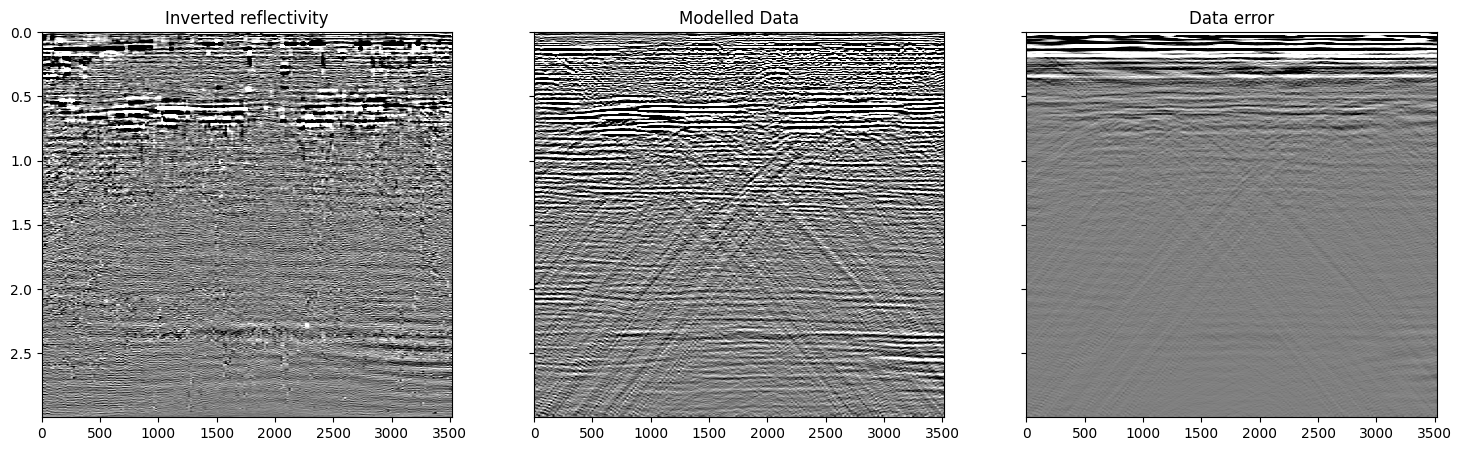

In [14]:
datainv = Top @ reflinv

scale = 30
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
axs[0].imshow(reflinv.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]),
              norm=colors.TwoSlopeNorm(vmin=np.min(reflinv)/scale, vcenter=0, vmax=np.max(reflinv)/scale))
axs[0].axis('tight')
axs[0].set_title('Inverted reflectivity')

axs[1].imshow(datainv.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]),
              norm=colors.TwoSlopeNorm(vmin=np.min(datainv)/scale, vcenter=0, vmax=np.max(datainv)/scale))
axs[1].axis('tight')
axs[1].set_title('Modelled Data')

axs[2].imshow(data_filt.T-datainv.T, cmap='gray', extent=(x[0], x[-1], t0[-1], t0[0]),
              norm=colors.TwoSlopeNorm(vmin=np.min(data_filt)/scale, vcenter=0, vmax=np.max(data_filt)/scale))
axs[2].axis('tight')
axs[2].set_title('Data error')

axs[2].set_ylim(t0[-1], t0[0]);

## Time to Depth Conversion

Using the RMS velocity model, the migrated image is converted from the **time domain (TWT)** to the **depth domain**.

**Depth Calculation:**
Depth $ z $ at each midpoint $( X_{mid} )$ is calculated as:
$$
z(t, x) = \int_0^t V_{RMS}(\tau, x) \, d\tau
$$
In discrete form:
$$
z(t_i, x) = \sum_{j=0}^{i-1} V_{RMS}(t_j, x) \cdot \Delta t
$$

**Steps:**
1. Compute the depth for each TWT sample.
2. Interpolate reflectivity amplitudes from the TWT grid to the depth grid.

**Output:**
- Depth-domain reflectivity image, plotted against \( X_{mid} \) and depth (m).

- The reflectors are now represented in depth, providing a clearer geological interpretation.

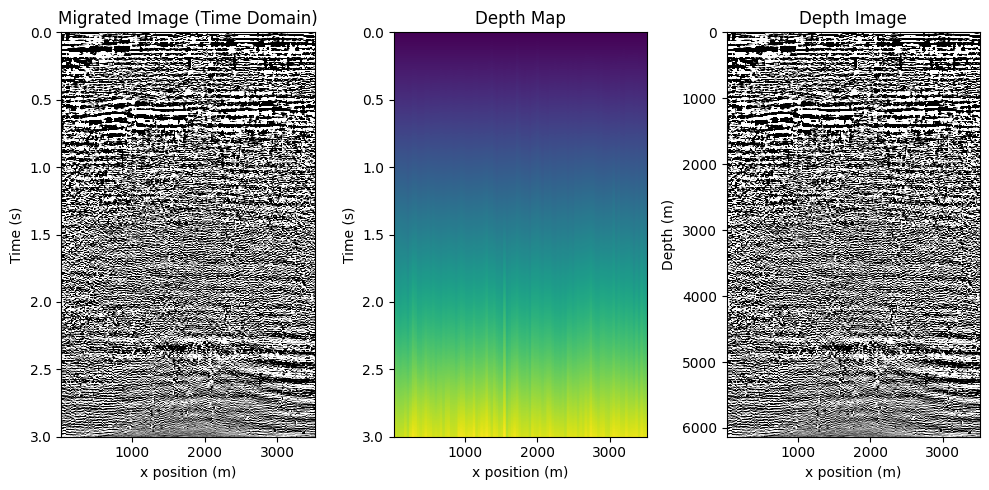

In [15]:
# Parameters
#nx, nt0
# Initialize depth grid
z_map = np.zeros_like(vrmsmodel)

# Compute depth for each time sample and spatial position
for ix in range(nx):  # Loop over spatial samples
    for it in range(1, nt0):  # Loop over time samples
        z_map[it, ix] = z_map[it-1, ix] + vrmsmodel[it-1, ix] * dt

# Initialize depth-domain image
depth_image = np.zeros_like(reflinv.T)

# Interpolate migrated image to depth grid
for ix in range(nx):  # Loop over spatial samples
    depth_image[:, ix] = np.interp(z_map[:, ix], z_map[:, ix], reflinv.T[:, ix])

scale = 100
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(reflinv.T, aspect='auto', cmap='gray', extent=[x[1], x[-1], nt0*dt, 0], norm=colors.TwoSlopeNorm(vmin=np.min(reflinv)/scale, vcenter=0, vmax=np.max(reflinv)/scale))
plt.title("Migrated Image (Time Domain)")
plt.xlabel("x position (m)")
plt.ylabel("Time (s)")

plt.subplot(1, 3, 2)
plt.imshow(z_map, aspect='auto', cmap='viridis', extent=[x[1], x[-1], nt0*dt, 0])
plt.title("Depth Map")
plt.xlabel("x position (m)")
plt.ylabel("Time (s)")

plt.subplot(1, 3, 3)
plt.imshow(depth_image, aspect='auto', cmap='gray', extent=[x[1], x[-1], z_map[-1, 0], 0], norm=colors.TwoSlopeNorm(vmin=np.min(depth_image)/scale, vcenter=0, vmax=np.max(depth_image)/scale))
plt.title("Depth Image")
plt.xlabel("x position (m)")
plt.ylabel("Depth (m)")

plt.tight_layout()
plt.show()